# Segmentation comparsion - Otsu vs. Gradient matching
use global gradient match threshold 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 1
%reload_ext autoreload
%load_ext line_profiler

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress
import scipy

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from cell_utilities import *
from metadata import *



Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
import skimage

%autoreload 1
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Seg_method_comparison_patches/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Seg_method_comparison_patches/

In [3]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 448
patch_half_size = patch_size / 2
stride = 112
# Crop images
# 
# crop_x_min = 9000
# crop_x_max = 10500
# crop_y_min = 3000
# crop_y_max = 4500

# Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Whole
crop_x_min = 0
crop_y_min = 0
_, _, crop_y_max, crop_x_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)

crop_image_width = crop_y_max - crop_y_min
crop_image_height = crop_x_max - crop_x_min

patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_height, crop_image_width))
patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

In [4]:
# Set examine section number range and download from S3 if not available
img_filename = []
secIndexList = range(200, 201)
n_images=0
for tempIndex1 in range(len(secIndexList)):
    if is_invalid(stack=stack, sec=secIndexList[tempIndex1]):
        secIndexList[tempIndex1]=-1
        sys.stderr.write('Invalid section sec = %s \n'%tempIndex1)
    else:
        img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))
        if os.path.isfile(img_filename[n_images]):
            sys.stderr.write('Image files are already available. \n')
            
        else:
            try:
                download_from_s3(img_filename[n_images])
            except:
                sys.stderr.write('Download fail. Skip this file...\n')
                          
        n_images = n_images + 1
while secIndexList.count(-1)>0:
    secIndexList.remove(-1)
n_images = len(img_filename)

Image files are already available. 


In [6]:
def fun_get_patch_imageList(image, patch_contour, patch_IndexList):
    imH,imW = np.shape(image);
    patch_image = [];
    for patch_Index in patch_IndexList:
        minRow = max(patch_contour[patch_Index,0,0],0);
        maxRow = min(patch_contour[patch_Index,2,0],imH);
        minCol = max(patch_contour[patch_Index,0,1],0);
        maxCol = min(patch_contour[patch_Index,2,1],imW);
#         if (minRow == maxRow) or (minCol == maxCol):
        if (minRow >= imH) or (minCol >=imW):
            print('Boundary. Skip')
            continue
        else:
            patch_image.append(image[minRow:maxRow,minCol:maxCol]);
#             = [im_cropped[0][patch_contour[patch_Index,0,0]:min(patch_contour[patch_Index,2,0],imH),
#                             patch_contour[patch_Index,0,1]:min(patch_contour[patch_Index,2,1],imW)].copy() for patch_Index in patch_IndexList]
    return patch_image  

In [7]:
# Read the whole images
option_rescale_grayscale = True
option_inverse_color = True

im_cropped = []
for imIndex in img_filename:
# for imIndex in [img_filename[0]]:
    if option_rescale_grayscale == False:
        im_cropped.append(img_as_ubyte(rgb2gray(imread(imIndex)[crop_x_min:crop_x_max, crop_y_min:crop_y_max])))
    else:
        im_cropped.append(fun_rescale_grayscale_image(img_as_ubyte(rgb2gray(imread(imIndex)[crop_x_min:crop_x_max, crop_y_min:crop_y_max])),invcol=option_inverse_color))


/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [8]:
patch_IndexList = range(len(patch_center_pixel_location))

In [9]:
patch_image = fun_get_patch_imageList(im_cropped[0],patch_contour=patch_contour,patch_IndexList=patch_IndexList)

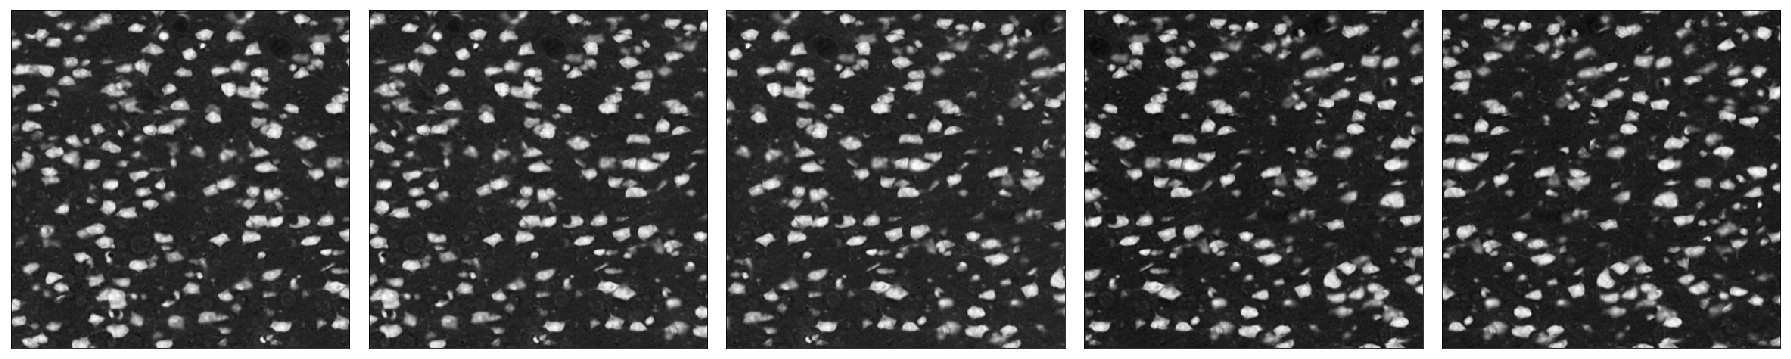

In [10]:
display_images_in_grids(patch_image[0:5],nc=5,cmap=plt.cm.gray)

# Is there an ideal threshold?

Threshold = 1.000000


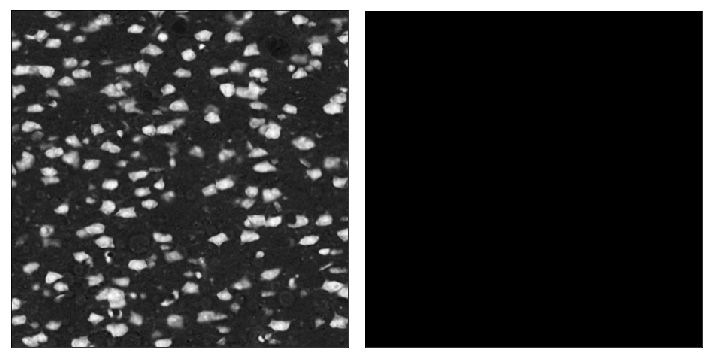

Threshold = 21.000000


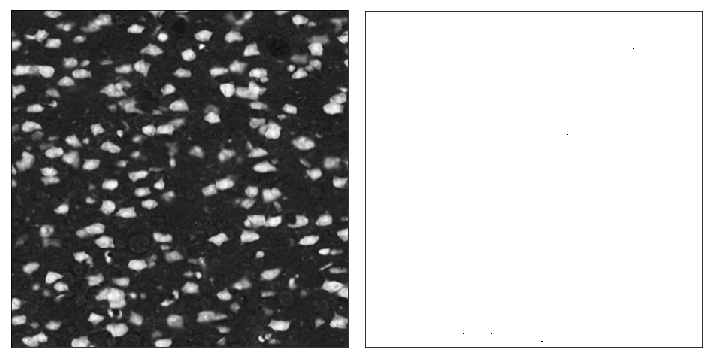

Threshold = 41.000000


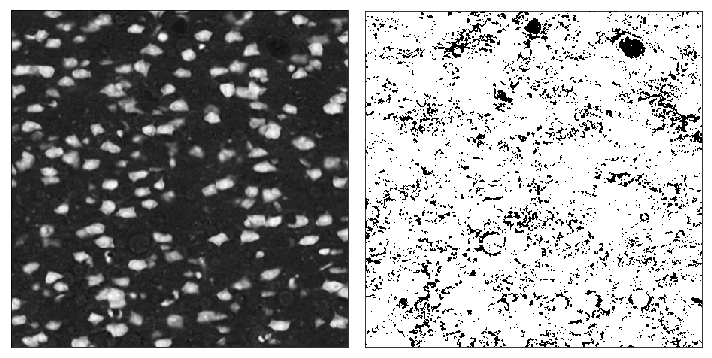

Threshold = 61.000000


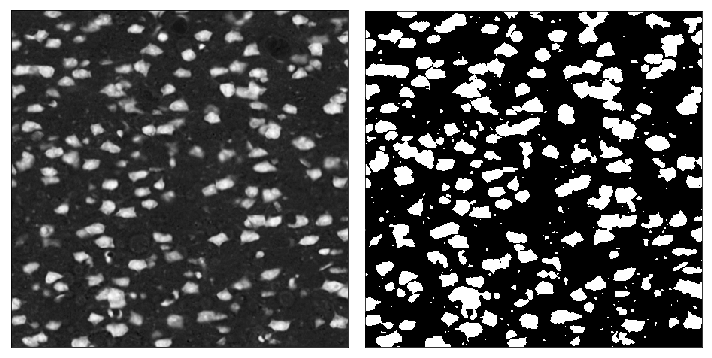

Threshold = 81.000000


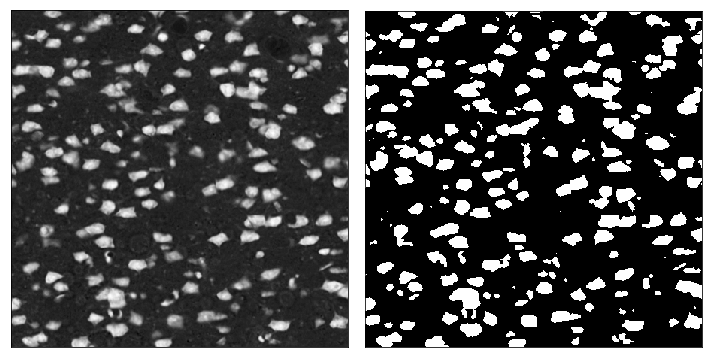

Threshold = 101.000000


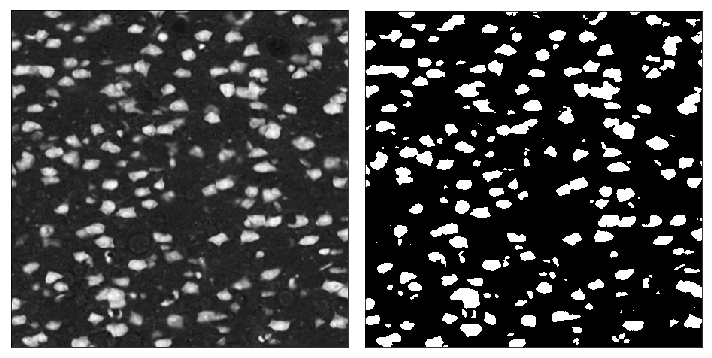

Threshold = 121.000000


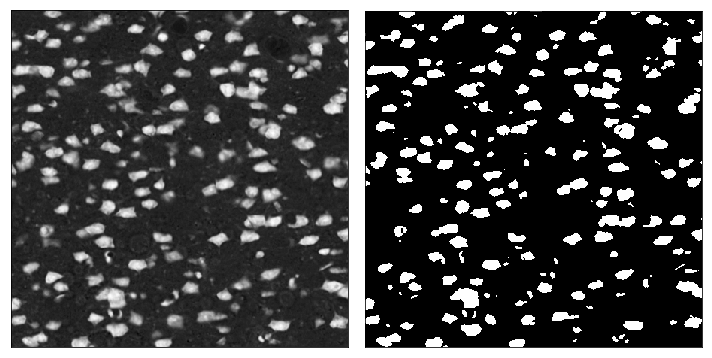

Threshold = 141.000000


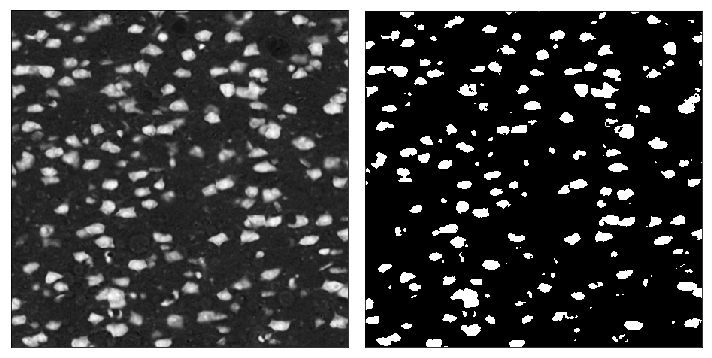

Threshold = 161.000000


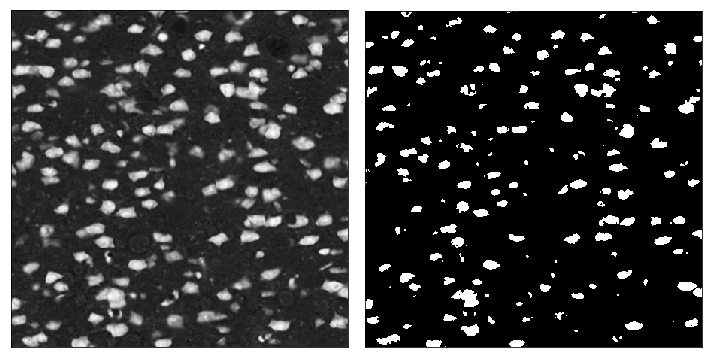

Threshold = 181.000000


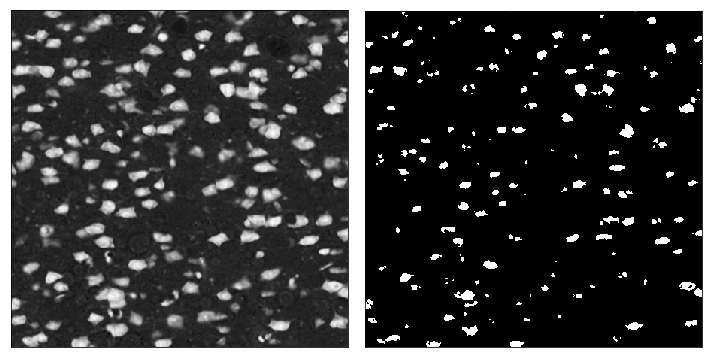

Threshold = 201.000000


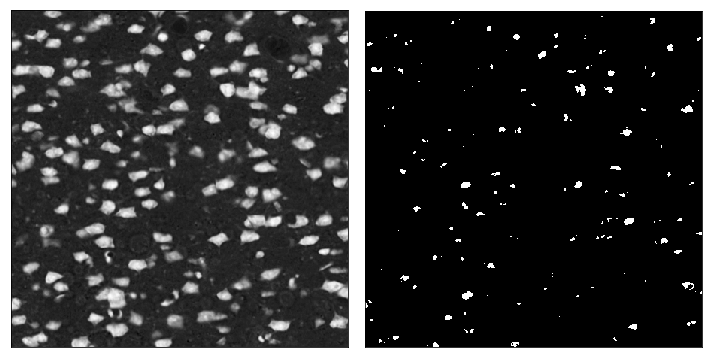

Threshold = 221.000000


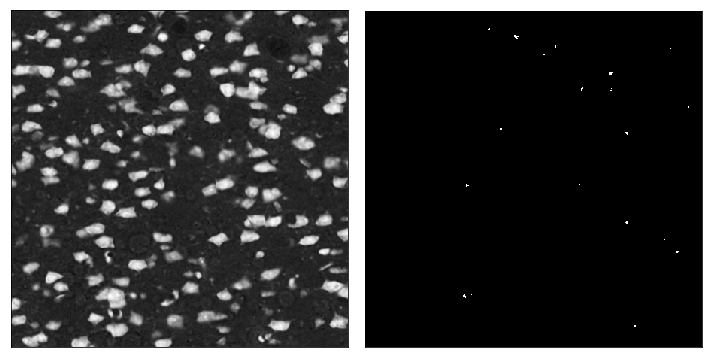

In [109]:
for tempTH in range(1,240,20):
    print('Threshold = %f'%tempTH)
    display_images_in_grids([patch_image[0], patch_image[0]>tempTH],nc=2,cmap=plt.cm.gray)
    

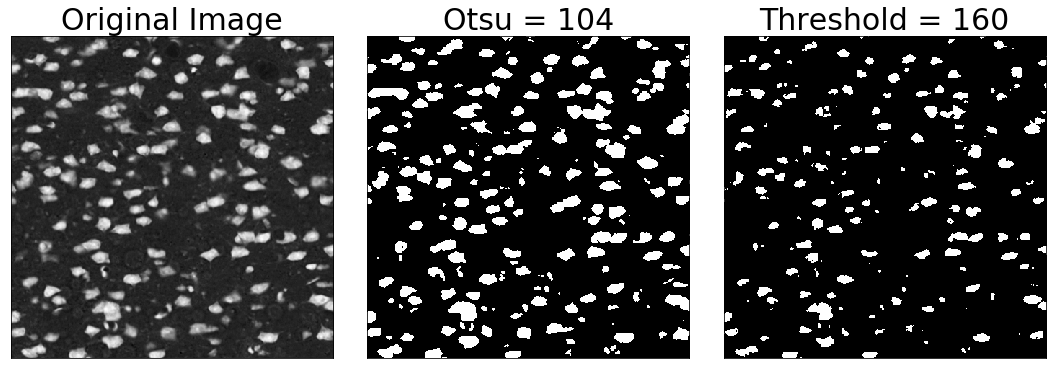

In [18]:
tempOtsu = skimage.filters.threshold_otsu(patch_image[0])
tempTH = 160
display_images_in_grids( [patch_image[0], patch_image[0] > tempOtsu, patch_image[0] > tempTH ], nc=3, cmap=plt.cm.gray, titles=['Original Image', 'Otsu = %d'% tempOtsu, 'Threshold = %d' % tempTH])

1. Otsu is fairly good in this case
2. When changing threshold, we get something new but also lose something. 
3. Let's try gradient alignement. 
4. Take thresholding as the first step, use some other method for further segmentation. 
    - Which threshold to use? 
    
    

# Gradient Alignment

In [76]:
patchIndex = 1
# Gaussian Filter
o_size_gaussfilt = 1;
if o_size_gaussfilt > 0:
    tempImage = (ndi.filters.gaussian_filter(patch_image[patchIndex], o_size_gaussfilt)).astype(np.float)
else:
    tempImage = patch_image[patchIndex];
# Compute the gradient in x, y direction of the origninal image
gradX, gradY = np.gradient(tempImage)

# Threshold scan
temp_TH_aggrement = {}
tempTH = 100
tempGx, tempGy = np.gradient((tempImage>tempTH).astype(np.float))
nz = np.logical_or(tempGx != 0, tempGy != 0)
np.average(tempGx[nz]*gradX[nz] + tempGy[nz]*gradY[nz])

14.372748232400861

In [77]:
np.set_printoptions(threshold=np.nan)

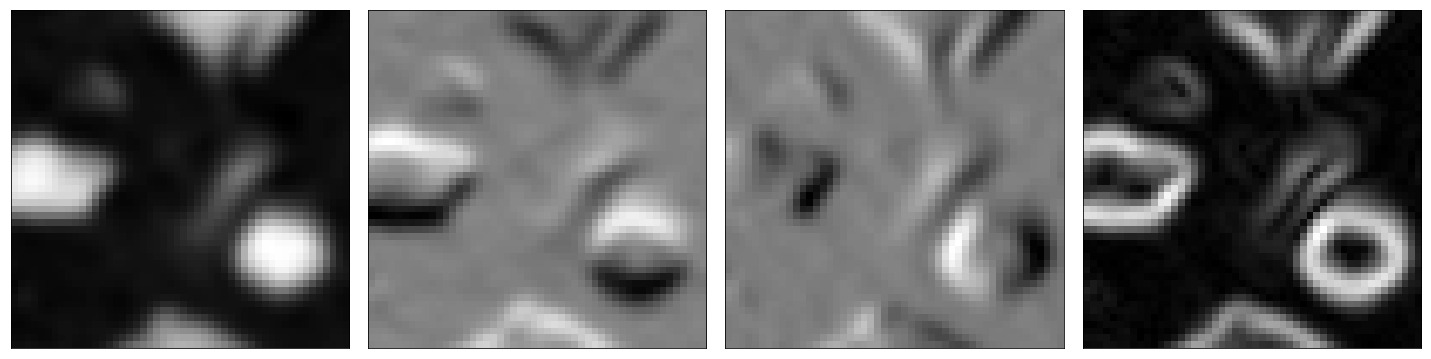

In [78]:
display_images_in_grids([tempImage[0:50,50:100], gradX[0:50,50:100],  gradY[0:50,50:100], np.sqrt(gradX[0:50,50:100] **2 + gradY[0:50,50:100] **2)],nc=4,cmap=plt.cm.gray)

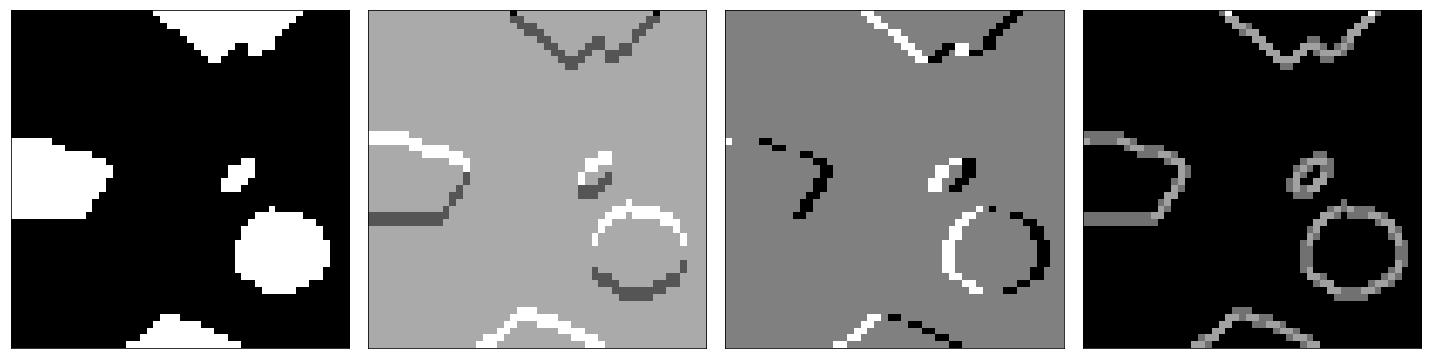

In [79]:
display_images_in_grids([(tempImage>tempTH).astype(np.float)[0:50,50:100], tempGx[0:50,50:100],  tempGy[0:50,50:100], np.sqrt(tempGx[0:50,50:100] **2 + tempGy[0:50,50:100] **2)],nc=4,cmap=plt.cm.gray)

# Integrated Function

In [103]:
# Function to find the threshold by gradient alignemnt

def fun_threshold_gradAlig(image,scanrange=(160,240),step=5,o_size_gaussfilt=1,o_return_scores=False,show_score_plot=True,method='avg_dot_pdt'):
    """
        image: a grayscale image(0-255)
        step: step for grayscale scan. can be integer number larger than 0
        o_size_gaussfilt: size of the gaussian filter. 
                          Not apply the gaussian filter to the image if equals 0
        method: (1)tot_dot_pdt; (2)avg_cos
        package needed: scipy.ndimage as ndi; numpy as np; matplotlib.pyplot as plt;  
        
    """
    if o_size_gaussfilt > 0:
        tempImage = (ndi.filters.gaussian_filter(image.astype(np.float), o_size_gaussfilt)) # ndi retuens the same type of array as image(uint array)
    else:
        tempImage = image.astype(np.float)
    gradX, gradY = np.gradient(tempImage)
#     print(np.count_nonzero(np.logical_and(gradX == 0, gradY == 0)))
    image_size = image.size
    temp_TH_aggrement = {}
    
    for tempTH in np.arange(scanrange[0],scanrange[1],step):
        tempGx, tempGy = np.gradient((tempImage > tempTH).astype(np.float))
#         print('Temporary Threshold %d'% tempTH)
#         display_images_in_grids([tempImage,tempGx **2 + tempGy **2, gradX **2 + gradY **2, (tempGx **2 + tempGy **2) * (gradX **2 + gradY **2)], nc=4, cmap=plt.cm.gray)
#         nz = np.logical_and(np.logical_or(tempGx != 0, tempGy != 0),np.logical_or(gradX != 0, gradY != 0))
        nz = np.logical_or(tempGx != 0, tempGy != 0)
#         plt.imshow(tempGx **2)
#         print("Nonzeros in TEMP %d " % np.count_nonzero(np.logical_or(tempGx != 0, tempGy != 0)));
#         print("Nonzeros in all %d "% np.count_nonzero(np.logical_and(np.logical_or(tempGx != 0, tempGy != 0),np.logical_or(gradX != 0, gradY != 0))))
        if np.count_nonzero(nz) == 0:
            temp_TH_aggrement[tempTH] = 0
        else:
            if method == 'tot_dot_pdt':
                    temp_TH_aggrement[tempTH] = np.sum(tempGx[nz]*gradX[nz] + tempGy[nz]*gradY[nz])
#                 temp_TH_aggrement[tempTH] = abs(np.sum(tempGx*gradX + tempGy*gradY))
            if method == 'avg_dot_pdt':
                temp_TH_aggrement[tempTH] = np.average(tempGx[nz]*gradX[nz] + tempGy[nz]*gradY[nz])
            if method == 'avg_cos':
                grad_norm = np.sqrt( gradX[nz] ** 2 + gradY[nz] ** 2 )
                tempG_norm = np.sqrt( tempGx[nz] ** 2 + tempGy[nz] ** 2 )
                temp_TH_aggrement[tempTH] = np.average((tempGx[nz]*gradX[nz] + tempGy[nz]*gradY[nz])/(tempG_norm * grad_norm + 0.000000000000001))
#         print("Aggrement: %f"% temp_TH_aggrement[tempTH])
    tempKeys, tempValues = zip(*sorted(temp_TH_aggrement.items()))
    grad_threshold = tempKeys[np.argmax(tempValues)]
    
    if show_score_plot==True:
        fig_grad_THscan_score = plt.figure()
        fig_grad_THscan_score = plt.plot(tempKeys, tempValues)
        fig_grad_THscan_score = plt.xlabel('Grayscale threshold')
        fig_grad_THscan_score = plt.ylabel('Score')
        fig_grad_THscan_score = plt.title('Score method used: '+method+'\nBest threshold = %s' % grad_threshold)
        fig_grad_THscan_score = plt.grid(True)
    if o_return_scores==True:
        return grad_threshold,[tempKeys,tempValues]
    else:
        return grad_threshold    

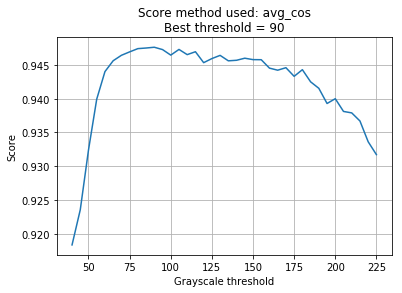

In [116]:
%lprun -f fun_threshold_gradAlig fun_threshold_gradAlig(patch_image[10],scanrange=(40,230),step=5,show_score_plot=True,method='avg_cos')

# Compute threshold for each patch:

In [117]:
otsu_th = [];
grad_align_th_dps = []
grad_align_th_cos = []
grad_align_th_dpa = []
option_Show_picture = False;
option_get_otsu = True
option_get_grad_align = True
option_get_grad_align_cos = False
option_get_grad_align_dpa = True
option_get_grad_align_dps = False
option_scanstep = 5
# errorPatch = [];
# for patch_index in patch_IndexList:
#     tempImage = patch_image[patch_index]
# #     if option_get_otsu:
#     otsu_th.append(skimage.filters.threshold_otsu(tempImage))
# #         im_BW_otsu.append(tempImage < otsu_th[imIndex])
# #     if option_get_grad_align:
#     print(patch_index)
# #         if option_get_grad_align_dps:
# #             grad_align_th_dps.append(fun_threshold_gradAlig(tempImage,scanrange=(10,240),step=option_scanstep,show_score_plot=True,method='tot_dot_pdt'))
# #         if option_get_grad_align_cos:
# #             grad_align_th_cos.append(fun_threshold_gradAlig(tempImage,scanrange=(10,240),step=option_scanstep,show_score_plot=True,method='avg_cos'))
# #         if option_get_grad_align_dpa:
#     grad_align_th_dpa.append(fun_threshold_gradAlig(tempImage,scanrange=(10,240),step=option_scanstep,show_score_plot=True,method='avg_dot_pdt'))
# #         im_BW_GA.append(tempImage < grad_align_th[imIndex])


In [118]:
from multiprocess import Pool

In [119]:
tempPool = Pool(4)
otsu_th = tempPool.map(lambda patch_index: skimage.filters.threshold_otsu(patch_image[patch_index]),patch_IndexList)
tempPool.close()
tempPool.join()

In [ ]:
tempPool = Pool(4)
grad_align_th_dpa = tempPool.map(lambda patch_index:fun_threshold_gradAlig(patch_image[patch_index],scanrange=(40,230),step=option_scanstep,show_score_plot=False,method='avg_dot_pdt') ,patch_IndexList)
tempPool.close()
tempPool.join()

In [ ]:
tempPool = Pool(4)
grad_align_th_dps = tempPool.map(lambda patch_index:fun_threshold_gradAlig(patch_image[patch_index],scanrange=(40,230),step=option_scanstep,show_score_plot=False,method='tot_dot_pdt') ,patch_IndexList)
tempPool.close()
tempPool.join()

In [ ]:
tempPool = Pool(4)
grad_align_th_cos = tempPool.map(lambda patch_index:fun_threshold_gradAlig(patch_image[patch_index],scanrange=(40,230),step=option_scanstep,show_score_plot=False,method='avg_cos') ,patch_IndexList)
tempPool.close()
tempPool.join()

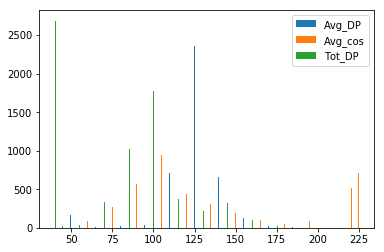

In [125]:
plt.hist([grad_align_th_dpa, grad_align_th_cos, grad_align_th_dps],255);
plt.legend(['Avg_DP','Avg_cos','Tot_DP'])

# Comparing Otsu vs Grad_align_tot

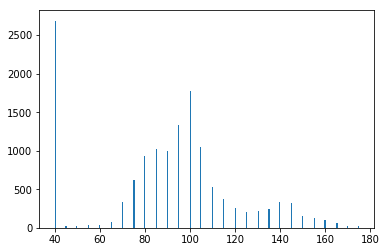

In [128]:
plt.hist(grad_align_th_dps,255);

In [129]:
stat_otsuDgrad_tot = np.array(otsu_th,dtype=float)/np.array(grad_align_th_dps,dtype=float)

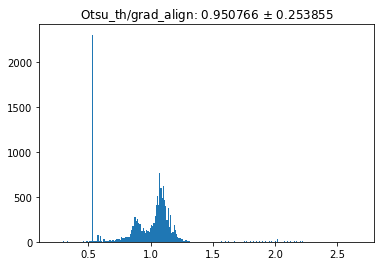

In [130]:
plt.hist(stat_otsuDgrad_tot,256);
plt.title('Otsu_th/grad_align: %f $\pm$ %f'%(np.mean(stat_otsuDgrad_tot),np.std(stat_otsuDgrad_tot)))

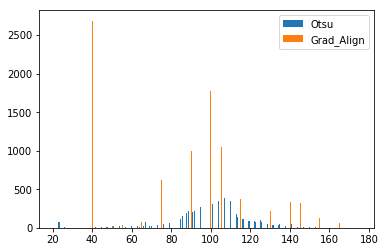

In [132]:
plt.hist([otsu_th, grad_align_th_dps],255);
plt.legend(['Otsu','Grad_Align'])

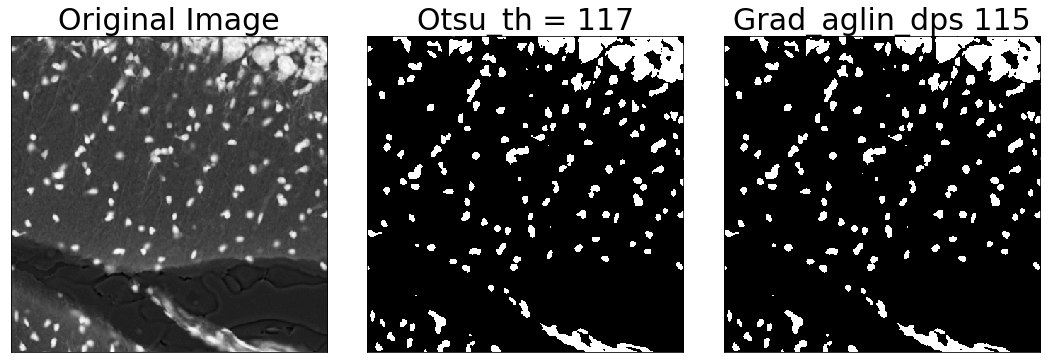

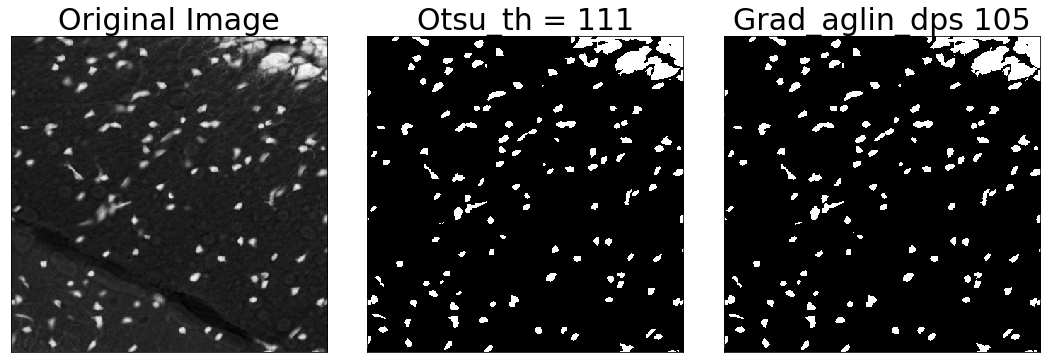

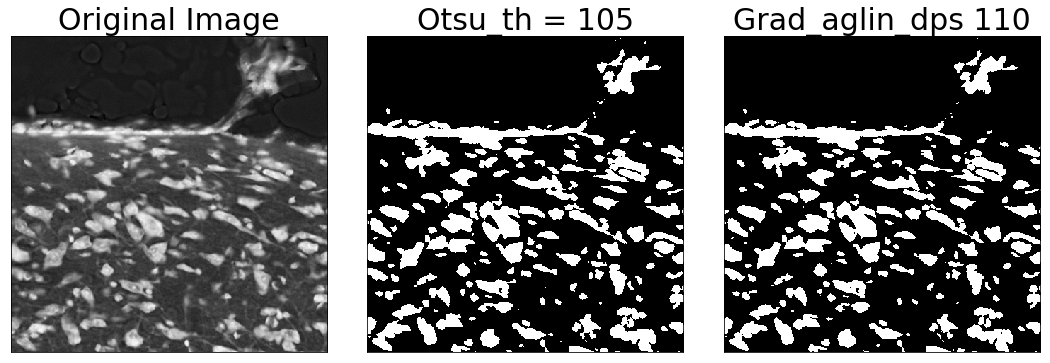

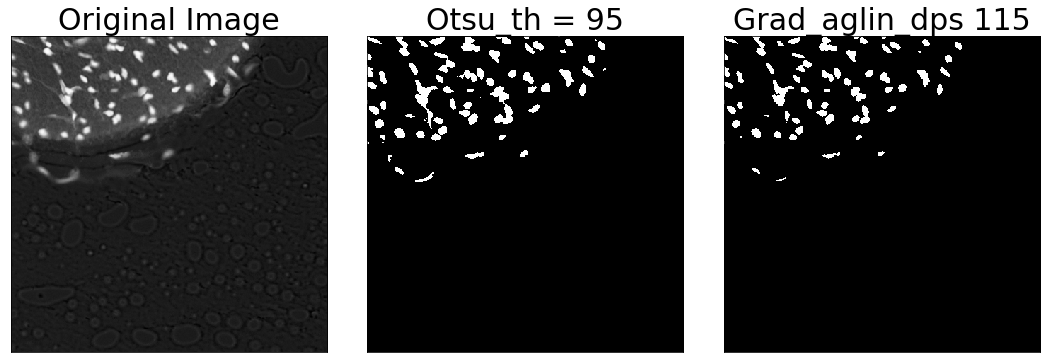

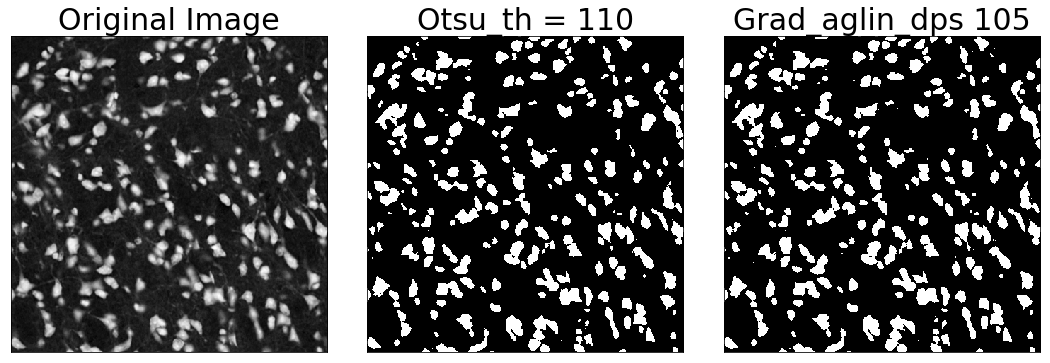

In [134]:
tempTHL150_dps = np.array(patch_IndexList)[np.logical_and(np.array(grad_align_th_dps)>100,np.array(grad_align_th_dps)<200)]
for patch_index in np.random.choice(tempTHL150_dps,5):
#     print('Otsu:%f    Grad_align %f'%(otsu_th[patch_index],grad_align_th_dpa[patch_index]))
    display_images_in_grids([patch_image[patch_index], patch_image[patch_index]>otsu_th[patch_index], patch_image[patch_index]>grad_align_th_dps[patch_index]], nc=3,cmap=plt.cm.gray, titles=['Original Image', 'Otsu_th = %d'%otsu_th[patch_index], 'Grad_aglin_dps %d'%grad_align_th_dps[patch_index]]) 

# Comparing Otsu  vs Grad_align_avg

In [135]:
stat_otsuDgrad = np.array(otsu_th,dtype=float)/np.array(grad_align_th_dpa,dtype=float)

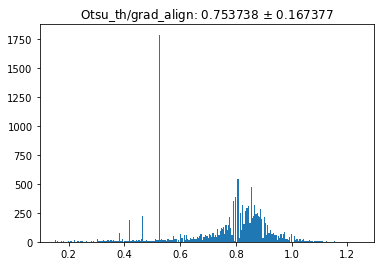

In [137]:
plt.hist(stat_otsuDgrad,255);
plt.title('Otsu_th/grad_align: %f $\pm$ %f'%(np.mean(stat_otsuDgrad),np.std(stat_otsuDgrad)))

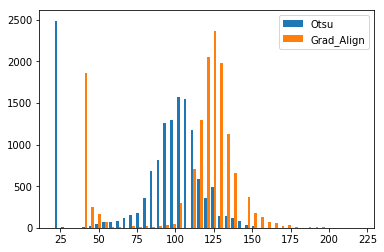

In [138]:
plt.hist([otsu_th, grad_align_th_dpa],45);
plt.legend(['Otsu','Grad_Align'])

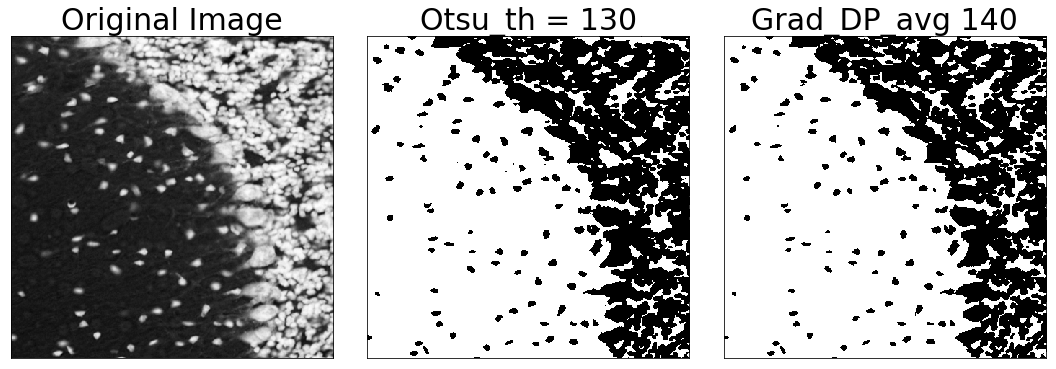

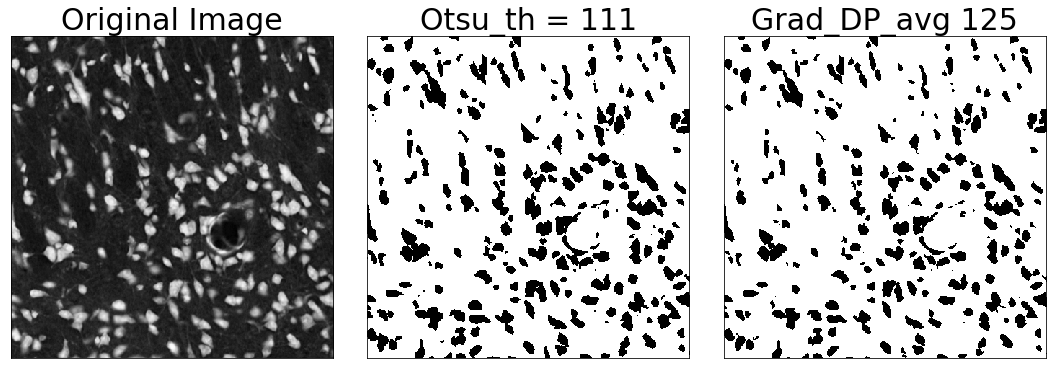

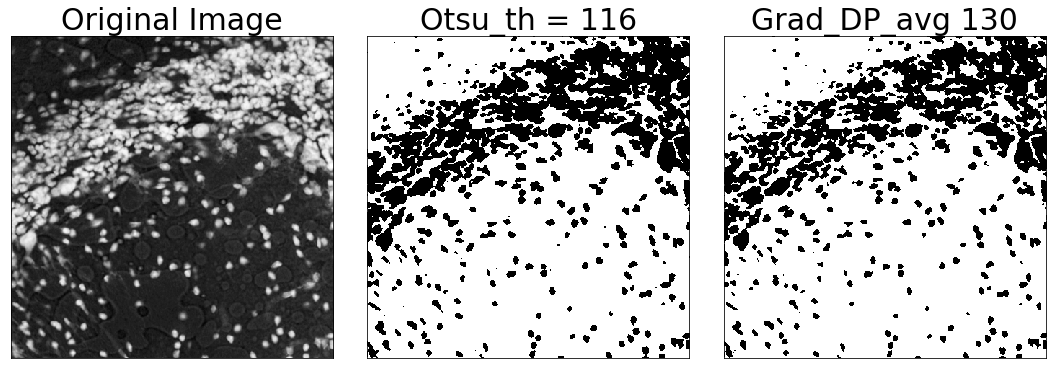

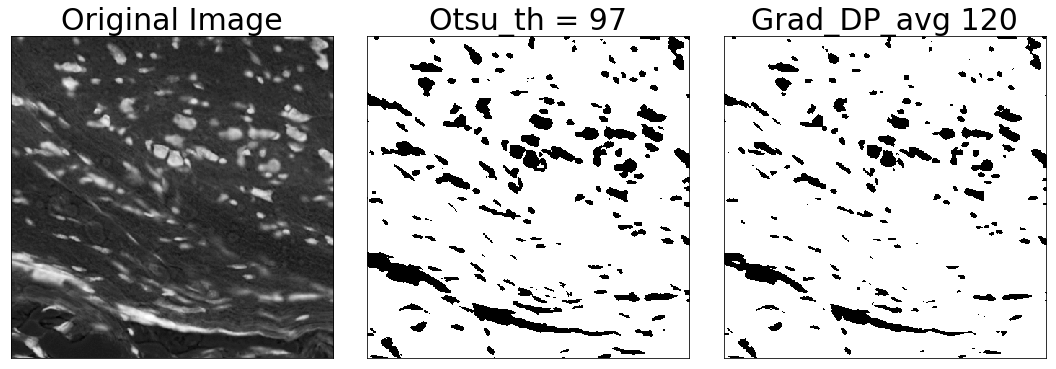

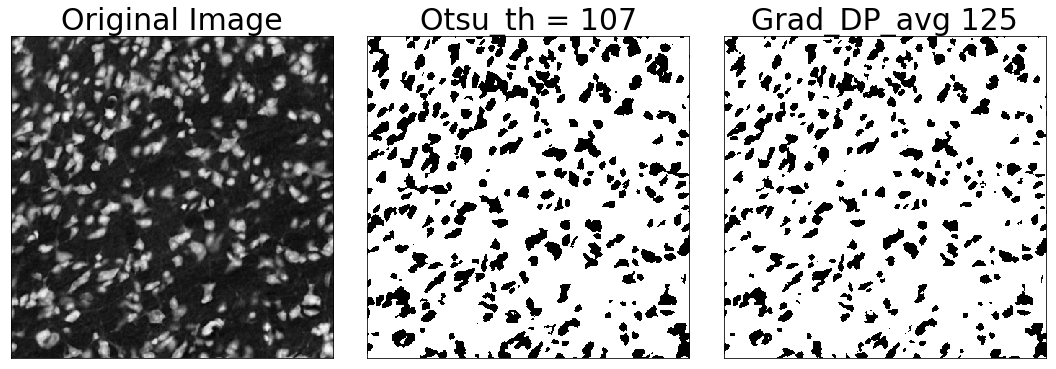

In [139]:
tempTHL150_avg = np.array(patch_IndexList)[np.logical_and(np.array(grad_align_th_dpa)>100,np.array(grad_align_th_dpa)<200)]
for patch_index in np.random.choice(tempTHL150_avg,5):
#     print('Otsu:%f    Grad_align %f'%(otsu_th[patch_index],grad_align_th_dpa[patch_index]))
    display_images_in_grids([patch_image[patch_index], patch_image[patch_index]<otsu_th[patch_index], patch_image[patch_index]<grad_align_th_dpa[patch_index]], nc=3,cmap=plt.cm.gray, titles=['Original Image', 'Otsu_th = %d'%otsu_th[patch_index], 'Grad_DP_avg %d'%grad_align_th_dpa[patch_index]]) 

# Comparing Otsu vs Grad_avg_cos

In [140]:
stat_otsuDgrad_cos = np.array(otsu_th,dtype=float)/np.array(grad_align_th_cos,dtype=float)

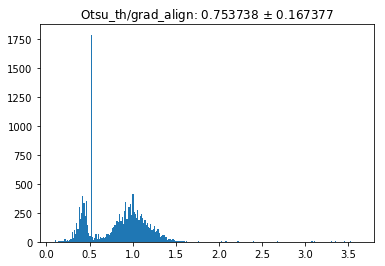

In [141]:
plt.hist(stat_otsuDgrad_cos,255);
plt.title('Otsu_th/grad_align: %f $\pm$ %f'%(np.mean(stat_otsuDgrad),np.std(stat_otsuDgrad)))

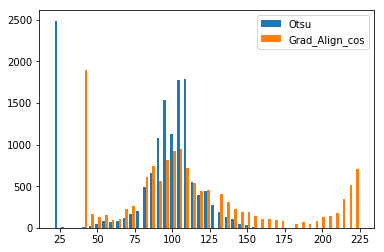

In [143]:
plt.hist([otsu_th, grad_align_th_cos],45);
plt.legend(['Otsu','Grad_Align_cos'])

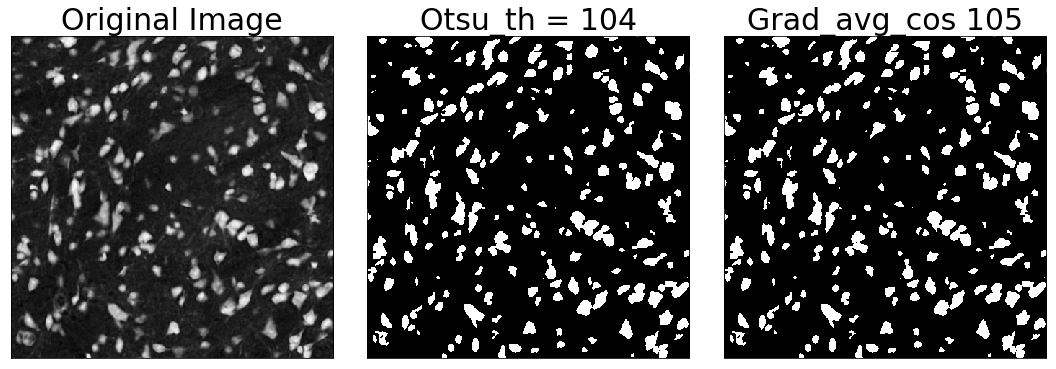

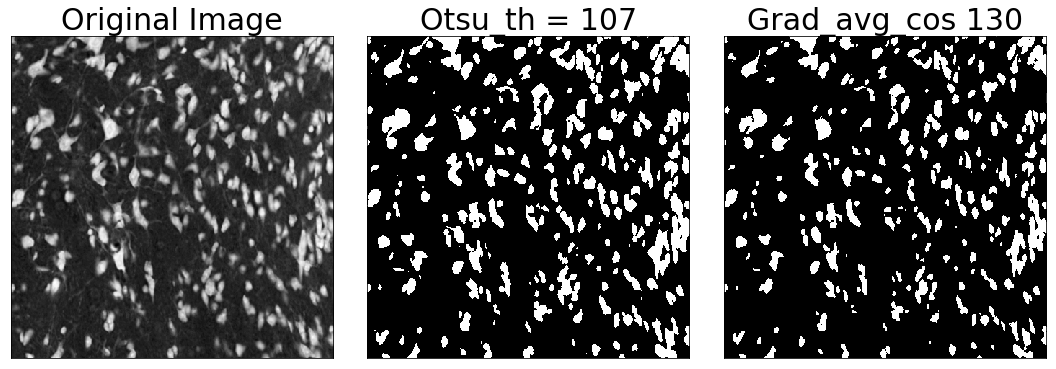

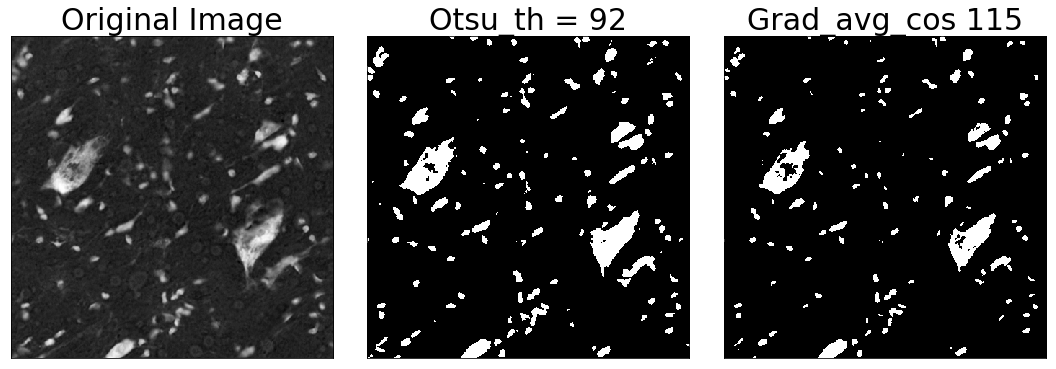

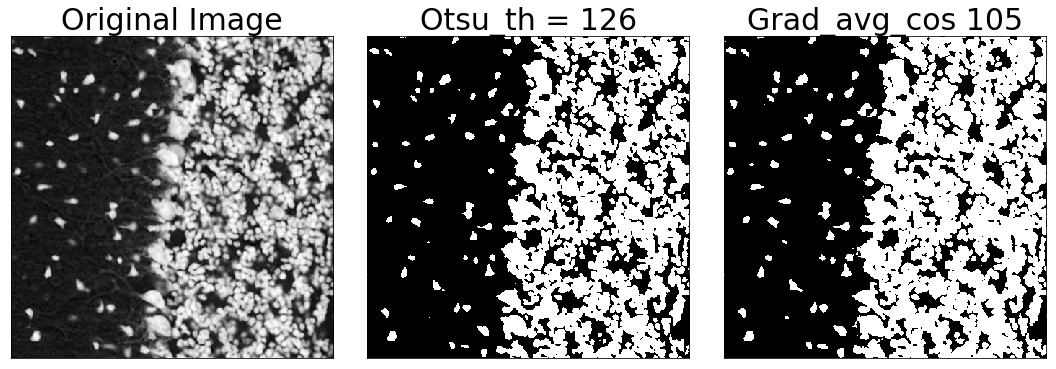

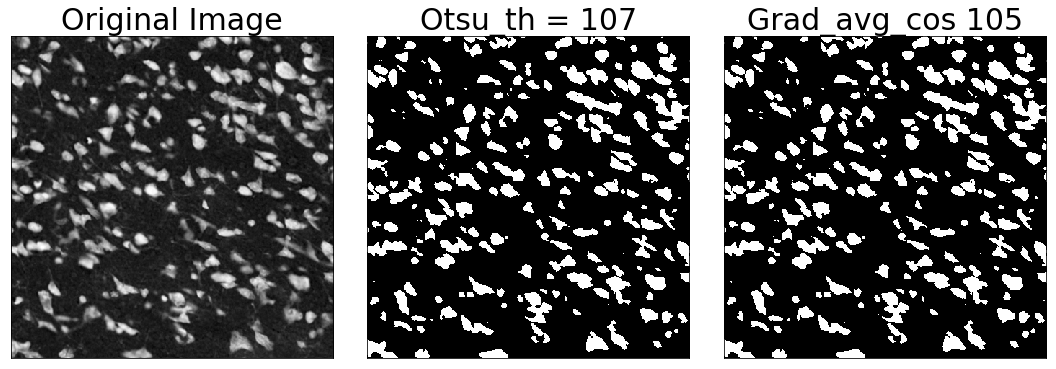

In [146]:
tempTHL150_cos = np.array(patch_IndexList)[np.logical_and(np.array(grad_align_th_cos)>100,np.array(grad_align_th_cos)<200)]
for patch_index in np.random.choice(tempTHL150_cos,5):
#     print('Otsu:%f    Grad_align %f'%(otsu_th[patch_index],grad_align_th_dpa[patch_index]))
    display_images_in_grids([patch_image[patch_index], patch_image[patch_index]>otsu_th[patch_index], patch_image[patch_index]>grad_align_th_cos[patch_index]], nc=3,cmap=plt.cm.gray, titles=['Original Image', 'Otsu_th = %d'%otsu_th[patch_index], 'Grad_avg_cos %d'%grad_align_th_cos[patch_index]]) 